In [1]:
text = 'Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'

In [2]:
import re

def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

In [4]:
tokens = tokenize(text)
tokens

['machine',
 'learning',
 'is',
 'the',
 'study',
 'of',
 'computer',
 'algorithms',
 'that',
 'improve',
 'automatically',
 'through',
 'experience',
 'it',
 'is',
 'seen',
 'as',
 'a',
 'subset',
 'of',
 'artificial',
 'intelligence',
 'machine',
 'learning',
 'algorithms',
 'build',
 'a',
 'mathematical',
 'model',
 'based',
 'on',
 'sample',
 'data',
 'known',
 'as',
 'training',
 'data',
 'in',
 'order',
 'to',
 'make',
 'predictions',
 'or',
 'decisions',
 'without',
 'being',
 'explicitly',
 'programmed',
 'to',
 'do',
 'so',
 'machine',
 'learning',
 'algorithms',
 'are',
 'used',
 'in',
 'a',
 'wide',
 'variety',
 'of',
 'applications',
 'such',
 'as',
 'email',
 'filtering',
 'and',
 'computer',
 'vision',
 'where',
 'it',
 'is',
 'difficult',
 'or',
 'infeasible',
 'to',
 'develop',
 'conventional',
 'algorithms',
 'to',
 'perform',
 'the',
 'needed',
 'tasks']

In [37]:
def mapping(tokens):
    word_to_id = {}
    id_to_word = {}
    
    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token
    
    return word_to_id, id_to_word

In [38]:
word_to_id, id_to_word = mapping(tokens)
word_to_id

{'machine': 0,
 'mathematical': 1,
 'and': 2,
 'such': 3,
 'decisions': 4,
 'programmed': 5,
 'wide': 6,
 'experience': 7,
 'make': 8,
 'vision': 9,
 'algorithms': 10,
 'known': 11,
 'variety': 12,
 'tasks': 13,
 'study': 14,
 'as': 15,
 'learning': 16,
 'intelligence': 17,
 'on': 18,
 'so': 19,
 'seen': 20,
 'artificial': 21,
 'without': 22,
 'a': 23,
 'predictions': 24,
 'filtering': 25,
 'conventional': 26,
 'of': 27,
 'being': 28,
 'where': 29,
 'email': 30,
 'it': 31,
 'improve': 32,
 'model': 33,
 'sample': 34,
 'perform': 35,
 'that': 36,
 'applications': 37,
 'order': 38,
 'are': 39,
 'data': 40,
 'subset': 41,
 'difficult': 42,
 'computer': 43,
 'or': 44,
 'infeasible': 45,
 'automatically': 46,
 'in': 47,
 'through': 48,
 'do': 49,
 'to': 50,
 'the': 51,
 'used': 52,
 'build': 53,
 'is': 54,
 'develop': 55,
 'needed': 56,
 'based': 57,
 'explicitly': 58,
 'training': 59}

In [41]:
def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res

In [43]:
def concat(*iterables):
    for iterable in iterables:
        yield from iterable

In [44]:
import numpy as np

np.random.seed(42)


def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))
    
    return np.asarray(X), np.asarray(y)

In [45]:
X, y = generate_training_data(tokens, word_to_id, 2)

In [46]:
X.shape

(330, 60)

In [47]:
y.shape

(330, 60)

In [48]:
def init_network(vocab_size, n_embedding):
    model = {
        "w1": np.random.randn(vocab_size, n_embedding),
        "w2": np.random.randn(n_embedding, vocab_size)
    }
    return model

In [49]:
model = init_network(len(word_to_id), 10)

In [50]:
def softmax(X):
    res = []
    for x in X:
        exp = np.exp(x)
        res.append(exp / exp.sum())
    return res

def forward(model, X, return_cache=True):
    cache = {}
    
    cache["a1"] = X @ model["w1"]
    cache["a2"] = cache["a1"] @ model["w2"]
    cache["z"] = softmax(cache["a2"])
    
    if not return_cache:
        return cache["z"]
    return cache

In [24]:
(X @ model["w1"]).shape

(330, 10)

In [26]:
(X @ model["w1"] @ model["w2"]).shape

(330, 60)

In [53]:
def cross_entropy(z, y):
    """Compute the cross-entropy loss for a softmax output z and target y."""
    return - np.sum(np.log(z) * y)

def backward(model, X, y, alpha):
    cache  = forward(model, X)
    da2 = cache["z"] - y
    dw2 = cache["a1"].T @ da2
    da1 = da2 @ model["w2"].T
    dw1 = X.T @ da1
    assert(dw2.shape == model["w2"].shape)
    assert(dw1.shape == model["w1"].shape)
    model["w1"] -= alpha * dw1
    model["w2"] -= alpha * dw2
    return cross_entropy(cache["z"], y)

C:\Users\mailt\AppData\Local\Temp\ipykernel_33260\1289573071.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


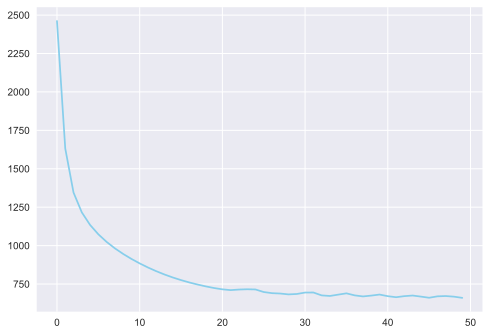

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn")

n_iter = 50
learning_rate = 0.05

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

In [55]:
learning = one_hot_encode(word_to_id["learning"], len(word_to_id))
result = forward(model, [learning], return_cache=False)[0]

for word in (id_to_word[id] for id in np.argsort(result)[::-1]):
    print(word)

machine
the
build
intelligence
so
are
is
seen
learning
algorithms
subset
perform
variety
applications
programmed
do
tasks
through
computer
such
or
difficult
explicitly
wide
conventional
model
develop
that
study
in
being
vision
automatically
used
infeasible
of
without
to
needed
experience
improve
known
artificial
email
sample
based
where
decisions
predictions
order
a
make
filtering
mathematical
as
training
and
data
it
on


In [56]:
model["w1"]

array([[ 1.10058992e+00,  5.24330264e-01,  1.31371257e+00,
        -1.79134537e-02, -1.46730217e+00, -2.69028034e-01,
         4.10562780e-01,  4.85681660e-01, -1.38979184e+00,
         1.06943479e-01],
       [-6.67825935e-01, -8.50520962e-01,  9.65691199e-01,
        -2.67272887e+00, -5.02810139e-01, -1.14354287e+00,
        -1.38166463e+00,  7.70335769e-01, -1.00456509e+00,
        -1.49625328e+00],
       [-2.42493370e-01, -2.48646096e-01, -1.76895179e+00,
        -1.16431748e+00, -2.75646302e-01, -2.46731317e-01,
         2.60282409e-01, -7.55204820e-01, -2.20467920e+00,
         6.78400732e-01],
       [-1.27868378e+00, -1.09885813e+00,  1.09259029e+00,
         6.77024039e-01,  7.32964922e-01, -3.51413436e-01,
         5.47733386e-01, -6.15157930e-01, -1.43222621e+00,
         1.13466083e+00],
       [ 1.58393964e+00, -1.57482684e-01, -3.62774472e-01,
        -2.58733734e-02, -1.27896040e+00,  1.21276427e+00,
        -1.22411734e+00,  1.47785650e+00,  6.33393043e-01,
        -1.

In [57]:
def get_embedding(model, word):
    try:
        idx = word_to_id[word]
    except KeyError:
        print("`word` not in corpus")
    one_hot = one_hot_encode(idx, len(word_to_id))
    return forward(model, one_hot)["a1"]

In [58]:
get_embedding(model, "machine")

array([ 1.10058992,  0.52433026,  1.31371257, -0.01791345, -1.46730217,
       -0.26902803,  0.41056278,  0.48568166, -1.38979184,  0.10694348])